# Problem 8.1

**Integrated Energy Grids**

**Problem 8.1. Join capacity and dispatch optimization.**

**Optimize the capacity and dispatch of solar PV, onshore wind, and Open Cycle Gas Turbine (OCGT) generators to supply the inelastic electricity demand throughout one year. 
To do this, take the time series for the wind and solar capacity factors for Portugal in 2015 obtained from https://zenodo.org/record/3253876#.XSiVOEdS8l0
and https://zenodo.org/record/2613651#.X0kbhDVS-uV (select the file ‘pvoptimal.csv’) and  the electricity demand from https://github.com/martavp/integrated-energy-grids/tree/main/integrated-energy-grids/Problems/data.**

**Consider the annualized capital costs and variable costs for the different technologies in the following table.**

**a) Calculate the total system cost, the optimal installed capacities, the annual generation per technology, and plot the hourly generation and demand during January.**

**b) Calculate the revenues collected by every technology throughout the year and show that their sum is equal to their costs.**

:::{note}
If you have not yet set up Python on your computer, you can execute this tutorial in your browser via [Google Colab](https://colab.research.google.com/). Click on the rocket in the top right corner and launch "Colab". If that doesn't work download the `.ipynb` file and import it in [Google Colab](https://colab.research.google.com/).

Then install `pandas` and `numpy` by executing the following command in a Jupyter cell at the top of the notebook.

```sh
!pip install pandas pypsa
```
:::

:::{note}
See also https://model.energy.
:::

In this exercise, we want to build a replica of [model.energy](https://model.energy). This tool calculates the cost of meeting a constant electricity demand from a combination of wind power, solar power and storage for different regions of the world. We deviate from [model.energy](https://model.energy) by including electricity demand profiles rather than a constant electricity demand. 

In [91]:
import matplotlib.pyplot as plt
import pandas as pd
import pypsa

## Prerequisites: handling technology data and costs

We maintain a database (https://github.com/PyPSA/technology-data) which collects assumptions and projections for energy system technologies (such as costs, efficiencies, lifetimes, etc.) for given years, which we can load into a `pandas.DataFrame`. This requires some pre-processing to load (e.g. converting units, setting defaults, re-arranging dimensions):

In [92]:
year = 2030
url = f"https://raw.githubusercontent.com/PyPSA/technology-data/master/outputs/costs_{year}.csv"
costs = pd.read_csv(url, index_col=[0, 1])

In [93]:
costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
costs.unit = costs.unit.str.replace("/kW", "/MW")

defaults = {
    "FOM": 0,
    "VOM": 0,
    "efficiency": 1,
    "fuel": 0,
    "investment": 0,
    "lifetime": 25,
    "CO2 intensity": 0,
    "discount rate": 0.07,
}
costs = costs.value.unstack().fillna(defaults)

costs.at["OCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["OCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]

Let's also write a small utility function that calculates the **annuity** to annualise investment costs. The formula is

$$
a(r, n) = \frac{r}{1-(1+r)^{-n}}
$$
where $r$ is the discount rate and $n$ is the lifetime.

In [94]:
def annuity(r, n):
    return r / (1.0 - 1.0 / (1.0 + r) ** n)

In [95]:
annuity(0.07, 20)

0.09439292574325567

Based on this, we can calculate the marginal generation costs (€/MWh):

In [96]:
costs["marginal_cost"] = costs["VOM"] + costs["fuel"] / costs["efficiency"]

and the annualised investment costs (`capital_cost` in PyPSA terms, €/MW/a):

In [97]:
annuity = costs.apply(lambda x: annuity(x["discount rate"], x["lifetime"]), axis=1)

In [98]:
costs["capital_cost"] = (annuity + costs["FOM"] / 100) * costs["investment"]

We can now read the capital and marginal cost of onshore wind, solar and OCGT

In [99]:
costs.at["onwind", "capital_cost"] #EUR/MW/a

101644.12332388277

In [100]:
costs.at["solar", "capital_cost"] #EUR/MW/a

51346.82981964593

In [101]:
costs.at["OCGT", "capital_cost"] #EUR/MW/a

47718.67056370105

In [102]:
costs.at["OCGT", "marginal_cost"] #EUR/MWh

64.6839512195122

## Retrieving time series data

In this example, wind data from [https://zenodo.org/record/3253876#.XSiVOEdS8l0](https://zenodo.org/record/3253876#.XSiVOEdS8l0) and solar PV data from [https://zenodo.org/record/2613651#.X0kbhDVS-uV](https://zenodo.org/record/3253876#.XSiVOEdS8l0) is used. The data is downloaded in csv format and saved in the 'data' folder.
The Pandas package is used as a convenient way of managing the datasets.

For convenience, the column including date information is converted into Datetime and set as index

In [103]:
data_solar = pd.read_csv('data/pv_optimal.csv',sep=';')
data_solar.index = pd.DatetimeIndex(data_solar['utc_time'])

data_wind = pd.read_csv('data/onshore_wind_1979-2017.csv',sep=';')
data_wind.index = pd.DatetimeIndex(data_wind['utc_time'])

data_el = pd.read_csv('data/electricity_demand.csv',sep=';')
data_el.index = pd.DatetimeIndex(data_el['utc_time'])

The data format can now be analyzed using the .head() function to show the first lines of the data set

In [104]:
data_solar.head()

,utc_time,AUT,BEL,BGR,BIH,CHE,CYP,CZE,DEU,DNK,...,MLT,NLD,NOR,POL,PRT,ROU,SRB,SVK,SVN,SWE
utc_time,,,,,,,,,,,,,,,,,,,,,
1979-01-01 00:00:00+00:00,1979-01-01T00:00:00Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1979-01-01 01:00:00+00:00,1979-01-01T01:00:00Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1979-01-01 02:00:00+00:00,1979-01-01T02:00:00Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1979-01-01 03:00:00+00:00,1979-01-01T03:00:00Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1979-01-01 04:00:00+00:00,1979-01-01T04:00:00Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We will use timeseries for Portugal in this excercise

In [105]:
country = 'PRT'

### Join capacity and dispatch optimization

For building the model, we start again by initialising an empty network, adding the snapshots, and the electricity bus.

In [106]:
n = pypsa.Network()
hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

n.set_snapshots(hours_in_2015.values)

n.add("Bus",
            "electricity")

n.snapshots

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00',
               ...
               '2015-12-31 14:00:00', '2015-12-31 15:00:00',
               '2015-12-31 16:00:00', '2015-12-31 17:00:00',
               '2015-12-31 18:00:00', '2015-12-31 19:00:00',
               '2015-12-31 20:00:00', '2015-12-31 21:00:00',
               '2015-12-31 22:00:00', '2015-12-31 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=8760, freq=None)

We add all the technologies we are going to include as carriers. Defining carriers is not mandatory but will ease plotting and assigning emissions of CO2 in future steps. 

In [109]:
carriers = [
    "onwind",
    "solar",
    "OCGT",
    "CCGT",
    "battery storage",
]

n.add(
    "Carrier",
    carriers,
    color=["dodgerblue", "gold", "indianred","yellow-green", "brown"],
    co2_emissions=[costs.at[c, "CO2 intensity"] for c in carriers],
)

Index(['onwind', 'solar', 'OCGT', 'CCGT', 'battery storage'], dtype='object')

Next, we add the demand time series to the model.

In [110]:
# add load to the bus
n.add("Load",
      "demand",
      bus="electricity",
      p_set=data_el[country].values)

Index(['demand'], dtype='object')

Let's have a check whether the data was read-in correctly.

<Axes: xlabel='snapshot', ylabel='MW'>

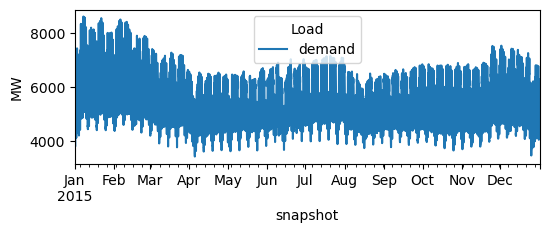

In [111]:
n.loads_t.p_set.plot(figsize=(6, 2), ylabel="MW")

We add now the generators and set up their capacities to be extendable so that they can be optimized together with the dispatch time series. For the wind and solar generator, we need to indicate the capacity factor or maximum power per unit 'p_max_pu'

In [112]:
n.add(
    "Generator",
    "OCGT",
    bus="electricity",
    carrier="OCGT",
    capital_cost=costs.at["OCGT", "capital_cost"],
    marginal_cost=costs.at["OCGT", "marginal_cost"],
    efficiency=costs.at["OCGT", "efficiency"],
    p_nom_extendable=True,
)

CF_wind = data_wind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
n.add(
        "Generator",
        "onwind",
        bus="electricity",
        carrier="onwind",
        p_max_pu=CF_wind.values,
        capital_cost=costs.at["onwind", "capital_cost"],
        marginal_cost=costs.at["onwind", "marginal_cost"],
        efficiency=costs.at["onwind", "efficiency"],
        p_nom_extendable=True,
    )

CF_solar = data_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
n.add(
        "Generator",
        "solar",
        bus="electricity",
        carrier="solar",
        p_max_pu= CF_solar.values,
        capital_cost=costs.at["solar", "capital_cost"],
        marginal_cost=costs.at["solar", "marginal_cost"],
        efficiency=costs.at["solar", "efficiency"],
        p_nom_extendable=True,
    )

Index(['solar'], dtype='object')

So let's make sure the capacity factors are read-in correctly.

<Axes: xlabel='snapshot', ylabel='CF'>

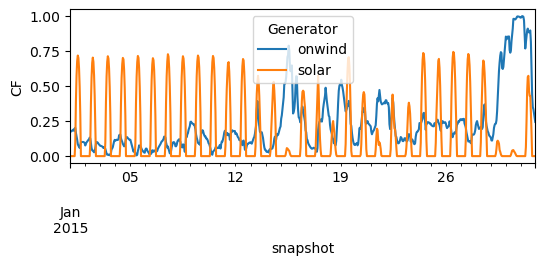

In [113]:
n.generators_t.p_max_pu.loc["2015-01"].plot(figsize=(6, 2), ylabel="CF")

### Model Run

We can already solved the model using the open-solver "highs" or the commercial solver "gurobi" with the academic license

In [114]:
n.optimize(solver_name="highs")

Index(['electricity'], dtype='object', name='Bus')
Index(['electricity'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 19.87it/s]
INFO:linopy.io: Writing time: 0.54s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 26283 primals, 61323 duals
Objective: 3.11e+09
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


('ok', 'optimal')

Now, we can look at the results and evaluate the total system cost (in billion Euros per year)

In [115]:
n.objective / 1e9

3.1120276518981047

The optimised capacities in GW:

In [116]:
n.generators.p_nom_opt.div(1e3)  # MW -> GW

Generator
OCGT      8.193448
onwind    5.241379
solar     8.371349
Name: p_nom_opt, dtype: float64

The total energy generation by technology in TWh:

In [117]:
n.generators_t.p.sum().div(1e6)  # MWh -> TWh

Generator
OCGT      26.974833
onwind     9.434456
solar     12.520371
dtype: float64

We can plot the dispatch of every generator thoughout January

<Axes: xlabel='snapshot', ylabel='dispatch'>

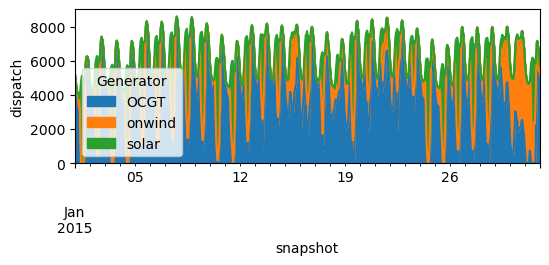

In [118]:
n.generators_t.p.loc["2015-01"].plot.area(figsize=(6, 2), ylabel="dispatch")

<Axes: xlabel='snapshot', ylabel='demand'>

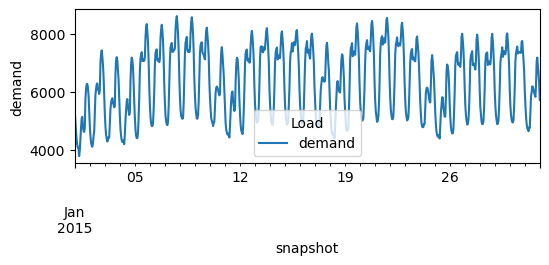

In [119]:
n.loads_t.p.loc["2015-01"].plot(figsize=(6, 2), ylabel="demand")

**b) Calculate the revenues collected by every technology throughout the year and show that their sum is equal to their costs.**

To calculate the revenues collected by every technology, for every generator, we multiply the energy generated in very hour by the electricity price in that hour and sum for the entire year.

In [120]:
n.generators_t.p.multiply(n.buses_t.marginal_price.to_numpy()).sum().div(1e6) # EUR -> MEUR

Generator
OCGT      2135.819257
onwind     546.233469
solar      429.974926
dtype: float64

This corresponds to the total cost for every technology, which we can also read using the statistics module:

In [121]:
(n.statistics.capex() + n.statistics.opex()).div(1e6)

component  carrier
Generator  OCGT       2135.819257
           onwind      546.233469
           solar       429.974926
dtype: float64